# Link Prediction

In [1]:
import networkx as nx
import random
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import torch
import numpy as np
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE, GAE
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

## 1. Data analysis

In [2]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")

In [3]:
print("number of nodes: ", len(g.nodes))
print("number of edges: ", len(g.edges))

number of nodes:  3363
number of edges:  13547


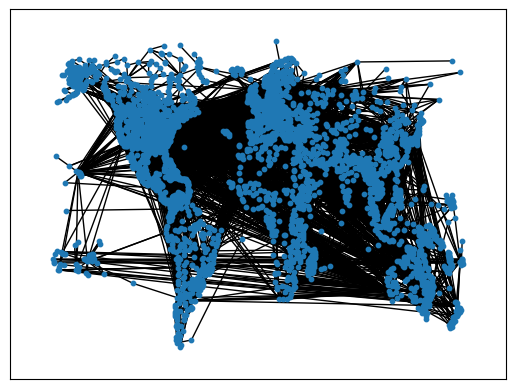

In [4]:
pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
nx.draw_networkx(g, pos=pos, node_size=10, with_labels=False)

With Gephi we have optain this graph:
![](./gephi_analyse/airports_coord_pop_graph.svg)

In [5]:
#Example of the a node
g.nodes()['0']

{'lon': -145.50972222222222,
 'lat': -17.35388888888889,
 'population': 10000,
 'country': 'FRENCH_POLYNESIA',
 'city_name': 'Anaa'}

In [6]:
g.graph = {}
data1 = from_networkx(g, group_node_attrs=["lon", "lat"])
data2 = from_networkx(g, group_node_attrs=["lon", "lat", "population"])
data1: Data = train_test_split_edges(data1, test_ratio=0.1)
data2: Data = train_test_split_edges(data2, test_ratio=0.1)
print(data1)
print(data2)

/home/valentin/.local/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 2], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])
Data(country=[3363], city_name=[3363], x=[3363, 3], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])


- x=[3363, 2] => pour chaque noeud, les coordonnées lat et lon
- val_pos_edge_index=[2, 677] => 2 ligne, la première c'est d'où on pars, la deuxième c'est où on va
- test_pos_edge_index=[2, 1354] => /
- train_pos_edge_index=[2, 23032] => /
- train_neg_adj_mask=[3363, 3363] => matrice d'adjacence, vrai si pas de lien, faux sinon
- val_neg_edge_index=[2, 677] => /
- test_neg_edge_index=[2, 1354] => /


## Modeles definitions and tested

### GAE with GAE Encoder

In [7]:
class GAEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [8]:
def trainGAE(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(model, data, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [9]:
model = GAE(GAEncoder(data1.num_features, 2))
optim = torch.optim.Adam(model.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
for epoch in range(500):
    better = False
    loss = trainGAE(model, optim, data1)

    auc, ap = test(model, data1, data1.val_pos_edge_index, data1.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bmodel = model
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print("##FINAL TEST##")
auc, ap = test(bmodel, data1, data1.test_pos_edge_index, data1.test_neg_edge_index)
print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))


    Epoch: 000, AUC: 0.6513, AP: 0.5912
    Epoch: 001, AUC: 0.6558, AP: 0.5953
    Epoch: 002, AUC: 0.6616, AP: 0.5992
    Epoch: 003, AUC: 0.6626, AP: 0.6000
    Epoch: 004, AUC: 0.6649, AP: 0.6020
Epoch: 005, AUC: 0.6630, AP: 0.5996
    Epoch: 006, AUC: 0.6669, AP: 0.6027
    Epoch: 007, AUC: 0.6725, AP: 0.6078
    Epoch: 008, AUC: 0.6761, AP: 0.6112
    Epoch: 009, AUC: 0.6848, AP: 0.6193
    Epoch: 010, AUC: 0.6868, AP: 0.6213
    Epoch: 011, AUC: 0.6916, AP: 0.6254
Epoch: 012, AUC: 0.6909, AP: 0.6255
Epoch: 013, AUC: 0.6889, AP: 0.6241
    Epoch: 014, AUC: 0.7009, AP: 0.6316
    Epoch: 015, AUC: 0.7072, AP: 0.6393
    Epoch: 016, AUC: 0.7161, AP: 0.6496
    Epoch: 017, AUC: 0.7220, AP: 0.6576
Epoch: 018, AUC: 0.7219, AP: 0.6593
    Epoch: 019, AUC: 0.7266, AP: 0.6630
    Epoch: 020, AUC: 0.7289, AP: 0.6639
    Epoch: 021, AUC: 0.7361, AP: 0.6701
    Epoch: 022, AUC: 0.7402, AP: 0.6737
    Epoch: 023, AUC: 0.7470, AP: 0.6789
    Epoch: 024, AUC: 0.7552, AP: 0.6875
    Epoch: 025, 

#### Visualise the map with the result of decoder

number of nodes: 3363
number of edges: 20664


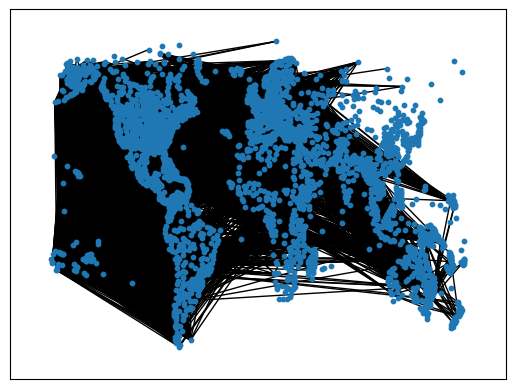

In [10]:
def visualise_output_prediction(bmodel, data, g):
    z = bmodel.encode(data.x, data.train_pos_edge_index)
    Ahat = torch.sigmoid(z @ z.T)
    Ahat = Ahat-torch.eye(len(Ahat), len(Ahat))
    rows, cols = np.where(Ahat > 0.98)
    edges = zip(rows.tolist(), cols.tolist())
    gr = g.copy()
    gr.remove_edges_from(list(gr.edges()))
    for u, v in edges:
        if str(u) in gr.nodes and str(v) in gr.nodes:
            gr.add_edge(str(u), str(v))
    print("number of nodes:", len(gr.nodes))
    print("number of edges:", len(gr.edges))
    pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
    nx.draw_networkx(gr, pos=pos, node_size=10, with_labels=False)
visualise_output_prediction(bmodel, data1, g)

### VGAE with VGAE encoder 

In [11]:
class VGAEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VGAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv_mu = GCNConv(2*out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2*out_channels, out_channels, cached=True)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [12]:
def trainVGAE(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

In [13]:
model = VGAE(VGAEncoder(data1.num_features, 2))
optim = torch.optim.Adam(model.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
for epoch in range(500):
    better = False
    loss = trainVGAE(model, optim, data1)

    auc, ap = test(model, data1, data1.val_pos_edge_index, data1.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bmodel = model
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print("##FINAL TEST##")
auc, ap = test(bmodel, data1, data1.test_pos_edge_index, data1.test_neg_edge_index)
print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))

    Epoch: 000, AUC: 0.6282, AP: 0.5743
    Epoch: 001, AUC: 0.6421, AP: 0.5839
    Epoch: 002, AUC: 0.6502, AP: 0.5900
    Epoch: 003, AUC: 0.6571, AP: 0.5951
    Epoch: 004, AUC: 0.6616, AP: 0.5983
    Epoch: 005, AUC: 0.6690, AP: 0.6037
    Epoch: 006, AUC: 0.6706, AP: 0.6048
    Epoch: 007, AUC: 0.6743, AP: 0.6076
    Epoch: 008, AUC: 0.6783, AP: 0.6106
    Epoch: 009, AUC: 0.6825, AP: 0.6139
    Epoch: 010, AUC: 0.6841, AP: 0.6151
    Epoch: 011, AUC: 0.6886, AP: 0.6187
    Epoch: 012, AUC: 0.6922, AP: 0.6216
Epoch: 013, AUC: 0.6919, AP: 0.6215
    Epoch: 014, AUC: 0.6951, AP: 0.6240
    Epoch: 015, AUC: 0.6960, AP: 0.6249
    Epoch: 016, AUC: 0.6974, AP: 0.6261
    Epoch: 017, AUC: 0.6976, AP: 0.6263
    Epoch: 018, AUC: 0.6992, AP: 0.6277
    Epoch: 019, AUC: 0.7002, AP: 0.6286
Epoch: 020, AUC: 0.7000, AP: 0.6284
    Epoch: 021, AUC: 0.7006, AP: 0.6292
    Epoch: 022, AUC: 0.7011, AP: 0.6298
    Epoch: 023, AUC: 0.7027, AP: 0.6314
    Epoch: 024, AUC: 0.7053, AP: 0.6340
Epoch: 0

### GatEncoder with VGAE

In [14]:
class GATEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.6)
        self.conv2_mu = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)
        self.conv2_logstd = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)
    

In [15]:
def trainGAT(model, opti, data):
    model.train()
    opti.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    opti.step()
    return float(loss)

In [16]:
modelGAT = VGAE(GATEncoder(input_dim=data1.num_node_features, hidden_dim=8, output_dim=16))
optim = torch.optim.Adam(modelGAT.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
bap = float("-inf")
for epoch in range(500):
    better = False
    loss = trainGAT(modelGAT, optim, data1)

    auc, ap = test(modelGAT, data1, data1.val_pos_edge_index, data1.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bap = ap
        bmodel = modelGAT
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print('BEST AUC: {:.4f}, AP: {:.4f}'.format(bauc, bap))

    Epoch: 000, AUC: 0.5000, AP: 0.5000
    Epoch: 001, AUC: 0.5465, AP: 0.5244
    Epoch: 002, AUC: 0.6288, AP: 0.5741
    Epoch: 003, AUC: 0.6384, AP: 0.5809
Epoch: 004, AUC: 0.5802, AP: 0.5442
Epoch: 005, AUC: 0.5199, AP: 0.5103
Epoch: 006, AUC: 0.5178, AP: 0.5091
Epoch: 007, AUC: 0.5126, AP: 0.5064
Epoch: 008, AUC: 0.5089, AP: 0.5045
Epoch: 009, AUC: 0.5022, AP: 0.5011
Epoch: 010, AUC: 0.5022, AP: 0.5011
Epoch: 011, AUC: 0.5059, AP: 0.5030
Epoch: 012, AUC: 0.5089, AP: 0.5045
Epoch: 013, AUC: 0.5096, AP: 0.5049
Epoch: 014, AUC: 0.5140, AP: 0.5071
Epoch: 015, AUC: 0.5148, AP: 0.5075
Epoch: 016, AUC: 0.5297, AP: 0.5153
Epoch: 017, AUC: 0.5475, AP: 0.5250
Epoch: 018, AUC: 0.5572, AP: 0.5304
Epoch: 019, AUC: 0.5720, AP: 0.5389
Epoch: 020, AUC: 0.6007, AP: 0.5563
Epoch: 021, AUC: 0.6274, AP: 0.5736
    Epoch: 022, AUC: 0.6464, AP: 0.5863
    Epoch: 023, AUC: 0.6483, AP: 0.5875
    Epoch: 024, AUC: 0.6568, AP: 0.5937
    Epoch: 025, AUC: 0.6653, AP: 0.6000
    Epoch: 026, AUC: 0.6710, AP:

## Hyperparameter tuning

For generating models, we choose to make a grid search with random values. For each models, we explore values for learning rate, output of encoder. We evaluates Models with AUC and AP. We evaluate 3 possibilities per hyper parameter. 

In [17]:
def hyperparameter_tuning_grid_search(data, output_values, lr_values, model, encoder, name_of_runs, train_fonction, hidden_values = [None]):
    for out in output_values:
        for hid in hidden_values:
            for lr in lr_values:
                if hid is not None:
                    trained_model = model(encoder(data.num_features, hid, out))
                else :
                    trained_model = model(encoder(data.num_features, out))
                optim = torch.optim.Adam(trained_model.parameters(), lr=lr)
                writer = SummaryWriter('runs/'+name_of_runs+f'/__{str(out)}_out_{str(lr)}_lr')
                bmodel = None
                bauc = float("-inf")
                bepoch = -1
                for epoch in range(500):
                    better = False
                    loss = train_fonction(trained_model, optim, data)
                    writer.add_scalar(
                        "train/loss", loss, epoch
                    )
                    auc, ap = test(trained_model, data, data.val_pos_edge_index, data.val_neg_edge_index)
                    writer.add_scalar(
                        "val/auc", auc, epoch
                    )
                    writer.add_scalar(
                        "val/ap", ap, epoch
                    )
                    if auc > bauc:
                        bauc = auc
                        bmodel = trained_model
                        better = True
                        bepoch = epoch
                    if better:
                        print('OUT: {:03d}, LR: {:.4f}, Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(out, lr, epoch, auc, ap))
                
                print("test")
                t_auc, t_ap = test(bmodel, data, data.test_pos_edge_index, data.test_neg_edge_index)
                print('AUC: {:.4f}, AP: {:.4f}'.format(t_auc, t_ap))
                print()
                writer.add_hparams(
                    {
                        "lr": lr,
                        "hidden value": hid,
                        "out": out,
                        "epoch": bepoch,
                    },
                    {
                        "hparam/AUC": t_auc,
                        "hparam/AP": t_ap,
                    },
                )
        

### GAE

In [18]:
output_values = [5, 7, 9, 11, 13, 15]
lr_values = [0.01, 0.005, 0.001, 0.0001]
hyperparameter_tuning_grid_search(data1, output_values, lr_values, GAE, GAEncoder, 'GAE_GAEncoder1', trainGAE)

OUT: 005, LR: 0.0100, Epoch: 000, AUC: 0.7027, AP: 0.6288
OUT: 005, LR: 0.0100, Epoch: 001, AUC: 0.7027, AP: 0.6284
OUT: 005, LR: 0.0100, Epoch: 002, AUC: 0.7050, AP: 0.6301
OUT: 005, LR: 0.0100, Epoch: 008, AUC: 0.7055, AP: 0.6302
OUT: 005, LR: 0.0100, Epoch: 009, AUC: 0.7058, AP: 0.6305
OUT: 005, LR: 0.0100, Epoch: 010, AUC: 0.7090, AP: 0.6331
OUT: 005, LR: 0.0100, Epoch: 011, AUC: 0.7095, AP: 0.6336
OUT: 005, LR: 0.0100, Epoch: 013, AUC: 0.7119, AP: 0.6357
OUT: 005, LR: 0.0100, Epoch: 014, AUC: 0.7134, AP: 0.6369
OUT: 005, LR: 0.0100, Epoch: 015, AUC: 0.7138, AP: 0.6373
OUT: 005, LR: 0.0100, Epoch: 016, AUC: 0.7149, AP: 0.6380
OUT: 005, LR: 0.0100, Epoch: 017, AUC: 0.7157, AP: 0.6386
OUT: 005, LR: 0.0100, Epoch: 019, AUC: 0.7164, AP: 0.6392
OUT: 005, LR: 0.0100, Epoch: 020, AUC: 0.7167, AP: 0.6395
OUT: 005, LR: 0.0100, Epoch: 021, AUC: 0.7182, AP: 0.6407
OUT: 005, LR: 0.0100, Epoch: 022, AUC: 0.7200, AP: 0.6423
OUT: 005, LR: 0.0100, Epoch: 035, AUC: 0.7200, AP: 0.6425
OUT: 005, LR: 

In [19]:
output_values = [5, 7, 9, 11, 13, 15]
lr_values = [0.01, 0.005, 0.001, 0.0001]
hyperparameter_tuning_grid_search(data2, output_values, lr_values, GAE, GAEncoder, 'GAE_GAEncoder2', trainGAE)

OUT: 005, LR: 0.0100, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 005, LR: 0.0050, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 005, LR: 0.0010, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 005, LR: 0.0001, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 007, LR: 0.0100, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 007, LR: 0.0050, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 007, LR: 0.0010, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 007, LR: 0.0001, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 009, LR: 0.0100, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 009, LR: 0.0050, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 009, LR: 0.0010, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 009, LR: 0.0001, Epoch: 000

### VGAE

#### with VGAEncoder

In [20]:
output_values = [5, 7, 9, 11, 13, 15]
lr_values = [0.01, 0.005, 0.001, 0.0001]
hyperparameter_tuning_grid_search(data1, output_values, lr_values, VGAE, VGAEncoder, 'VGAE_VGAEncoder1', trainVGAE)

OUT: 005, LR: 0.0100, Epoch: 000, AUC: 0.7020, AP: 0.6284
OUT: 005, LR: 0.0100, Epoch: 001, AUC: 0.7034, AP: 0.6298
OUT: 005, LR: 0.0100, Epoch: 012, AUC: 0.7036, AP: 0.6305
OUT: 005, LR: 0.0100, Epoch: 013, AUC: 0.7057, AP: 0.6323
OUT: 005, LR: 0.0100, Epoch: 014, AUC: 0.7069, AP: 0.6333
OUT: 005, LR: 0.0100, Epoch: 015, AUC: 0.7096, AP: 0.6355
OUT: 005, LR: 0.0100, Epoch: 016, AUC: 0.7158, AP: 0.6409
OUT: 005, LR: 0.0100, Epoch: 017, AUC: 0.7194, AP: 0.6440
OUT: 005, LR: 0.0100, Epoch: 018, AUC: 0.7267, AP: 0.6504
OUT: 005, LR: 0.0100, Epoch: 020, AUC: 0.7287, AP: 0.6522
OUT: 005, LR: 0.0100, Epoch: 021, AUC: 0.7318, AP: 0.6550
OUT: 005, LR: 0.0100, Epoch: 022, AUC: 0.7383, AP: 0.6609
OUT: 005, LR: 0.0100, Epoch: 024, AUC: 0.7439, AP: 0.6662
OUT: 005, LR: 0.0100, Epoch: 025, AUC: 0.7468, AP: 0.6684
OUT: 005, LR: 0.0100, Epoch: 026, AUC: 0.7515, AP: 0.6725
OUT: 005, LR: 0.0100, Epoch: 027, AUC: 0.7523, AP: 0.6728
OUT: 005, LR: 0.0100, Epoch: 028, AUC: 0.7530, AP: 0.6731
OUT: 005, LR: 

In [21]:
output_values = [5, 7, 9, 11, 13, 15]
lr_values = [0.01, 0.005, 0.001, 0.0001]
hyperparameter_tuning_grid_search(data2, output_values, lr_values, VGAE, VGAEncoder, 'VGAE_VGAEncoder2', trainVGAE)

OUT: 005, LR: 0.0100, Epoch: 000, AUC: 0.5000, AP: 0.5000
OUT: 005, LR: 0.0100, Epoch: 029, AUC: 0.5067, AP: 0.5034
OUT: 005, LR: 0.0100, Epoch: 030, AUC: 0.5171, AP: 0.5087
OUT: 005, LR: 0.0100, Epoch: 031, AUC: 0.5202, AP: 0.5103
OUT: 005, LR: 0.0100, Epoch: 032, AUC: 0.5286, AP: 0.5148
OUT: 005, LR: 0.0100, Epoch: 033, AUC: 0.5609, AP: 0.5334
OUT: 005, LR: 0.0100, Epoch: 034, AUC: 0.5890, AP: 0.5488
test
AUC: 0.5000, AP: 0.5000

OUT: 005, LR: 0.0050, Epoch: 000, AUC: 0.5000, AP: 0.5000
OUT: 005, LR: 0.0050, Epoch: 079, AUC: 0.5007, AP: 0.5004
OUT: 005, LR: 0.0050, Epoch: 080, AUC: 0.5022, AP: 0.5011
OUT: 005, LR: 0.0050, Epoch: 081, AUC: 0.5052, AP: 0.5026
OUT: 005, LR: 0.0050, Epoch: 082, AUC: 0.5229, AP: 0.5117
OUT: 005, LR: 0.0050, Epoch: 083, AUC: 0.5413, AP: 0.5216
OUT: 005, LR: 0.0050, Epoch: 084, AUC: 0.5487, AP: 0.5256
OUT: 005, LR: 0.0050, Epoch: 118, AUC: 0.5555, AP: 0.5294
OUT: 005, LR: 0.0050, Epoch: 119, AUC: 0.5673, AP: 0.5361
OUT: 005, LR: 0.0050, Epoch: 120, AUC: 0.5

#### with GATEncoder

In [ ]:
hidden_values = [60, 90]
output_values = [11, 13]
lr_values = [0.01, 0.001]
hyperparameter_tuning_grid_search(data1, output_values, lr_values, VGAE, GATEncoder, 'VGAE_GATEncoder1', trainGAT, hidden_values=hidden_values)

OUT: 011, LR: 0.0100, Epoch: 000, AUC: 0.5503, AP: 0.5265
OUT: 011, LR: 0.0100, Epoch: 001, AUC: 0.6251, AP: 0.5721
OUT: 011, LR: 0.0100, Epoch: 002, AUC: 0.6464, AP: 0.5865
OUT: 011, LR: 0.0100, Epoch: 003, AUC: 0.6606, AP: 0.5972
OUT: 011, LR: 0.0100, Epoch: 004, AUC: 0.6788, AP: 0.6111
OUT: 011, LR: 0.0100, Epoch: 005, AUC: 0.6819, AP: 0.6134
OUT: 011, LR: 0.0100, Epoch: 006, AUC: 0.6856, AP: 0.6165
OUT: 011, LR: 0.0100, Epoch: 007, AUC: 0.6877, AP: 0.6191
OUT: 011, LR: 0.0100, Epoch: 011, AUC: 0.6921, AP: 0.6229
OUT: 011, LR: 0.0100, Epoch: 012, AUC: 0.7161, AP: 0.6409
OUT: 011, LR: 0.0100, Epoch: 013, AUC: 0.7171, AP: 0.6414
OUT: 011, LR: 0.0100, Epoch: 077, AUC: 0.7204, AP: 0.6463
OUT: 011, LR: 0.0100, Epoch: 078, AUC: 0.7237, AP: 0.6489
OUT: 011, LR: 0.0100, Epoch: 178, AUC: 0.7273, AP: 0.6513
OUT: 011, LR: 0.0100, Epoch: 179, AUC: 0.7316, AP: 0.6547
OUT: 011, LR: 0.0100, Epoch: 180, AUC: 0.7353, AP: 0.6579
OUT: 011, LR: 0.0100, Epoch: 181, AUC: 0.7370, AP: 0.6592
OUT: 011, LR: 

In [23]:
hidden_values = [60, 90]
output_values = [11, 13]
lr_values = [0.01, 0.001]
hyperparameter_tuning_grid_search(data2, output_values, lr_values, VGAE, GATEncoder, 'VGAE_GATEncoder2', trainGAT, hidden_values=hidden_values)

OUT: 011, LR: 0.0100, Epoch: 000, AUC: 0.5000, AP: 0.5000
OUT: 011, LR: 0.0100, Epoch: 031, AUC: 0.5229, AP: 0.5117
OUT: 011, LR: 0.0100, Epoch: 098, AUC: 0.5281, AP: 0.5145
OUT: 011, LR: 0.0100, Epoch: 154, AUC: 0.5864, AP: 0.5479
OUT: 011, LR: 0.0100, Epoch: 155, AUC: 0.5989, AP: 0.5558
OUT: 011, LR: 0.0100, Epoch: 156, AUC: 0.5990, AP: 0.5559
test
AUC: 0.5000, AP: 0.5000

OUT: 011, LR: 0.0010, Epoch: 000, AUC: 0.5000, AP: 0.5000
test
AUC: 0.5000, AP: 0.5000

OUT: 011, LR: 0.0100, Epoch: 000, AUC: 0.5000, AP: 0.5000
OUT: 011, LR: 0.0100, Epoch: 027, AUC: 0.5835, AP: 0.5465
OUT: 011, LR: 0.0100, Epoch: 088, AUC: 0.5886, AP: 0.5492
OUT: 011, LR: 0.0100, Epoch: 089, AUC: 0.5968, AP: 0.5545
OUT: 011, LR: 0.0100, Epoch: 360, AUC: 0.6004, AP: 0.5570
OUT: 011, LR: 0.0100, Epoch: 394, AUC: 0.6034, AP: 0.5593
test
AUC: 0.5628, AP: 0.5340

OUT: 011, LR: 0.0010, Epoch: 000, AUC: 0.5000, AP: 0.5000
OUT: 011, LR: 0.0010, Epoch: 004, AUC: 0.5982, AP: 0.5555
OUT: 011, LR: 0.0010, Epoch: 459, AUC: 0

## Ablation Study

In [30]:
class GAEncoderAb1(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb1, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

class GAEncoderAb2(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb2, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return x
    
class GAEncoderAb3(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb3, self).__init__()
        self.conv1 = GCNConv(in_channels, 4*out_channels, cached=True)
        self.conv2 = GCNConv(4*out_channels, 2*out_channels, cached=True)
        self.conv3 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv3(x, edge_index)
    
class GAEncoderAb4(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb4, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).softmax(1)
        return self.conv2(x, edge_index)

class GAEncoderAb5(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb5, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).sigmoid()
        return self.conv2(x, edge_index)

class GAEncoderAb6(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb6, self).__init__()
        self.conv1 = GCNConv(in_channels, 4*out_channels, cached=True)
        self.conv2 = GCNConv(4*out_channels, 2*out_channels, cached=True)
        self.conv3 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).sigmoid()
        return self.conv3(x, edge_index)

class GAEncoderAb7(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb7, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels)
        self.conv2 = GCNConv(2*out_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    
class GAEncoderAb8(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb8, self).__init__()
        self.conv1 = GCNConv(in_channels, 8*out_channels, cached=True)
        self.conv2 = GCNConv(8*out_channels, 4*out_channels, cached=True)
        self.conv3 = GCNConv(4*out_channels, 2*out_channels, cached=True)
        self.conv4 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).sigmoid()
        return self.conv4(x, edge_index)

In [29]:
def ablation_study(data, out, lr, encoder, name_of_runs):
	trained_model = GAE(encoder(data.num_features, out))
	optim = torch.optim.Adam(trained_model.parameters(), lr=lr)
	writer = SummaryWriter('runs/ablation_study/'+name_of_runs)
	bmodel = None
	bauc = float("-inf")
	bepoch = -1
	print(f'Encoder: {name_of_runs}')
	for epoch in range(500):
		better = False
		loss = trainGAE(trained_model, optim, data)
		writer.add_scalar(
			"train/loss", loss, epoch
		)
		auc, ap = test(trained_model, data, data.val_pos_edge_index, data.val_neg_edge_index)
		writer.add_scalar(
			"val/auc", auc, epoch
		)
		writer.add_scalar(
			"val/ap", ap, epoch
		)
		if auc > bauc:
			bauc = auc
			bmodel = trained_model
			better = True
			bepoch = epoch
		if better:
			print(f'Epoch: {epoch}')
	print("test")
	t_auc, t_ap = test(bmodel, data, data.test_pos_edge_index, data.test_neg_edge_index)
	print('AUC: {:.4f}, AP: {:.4f}'.format(t_auc, t_ap))
	print()
	writer.add_hparams(
		{
			"name": name_of_runs,
			"epoch": bepoch,
		},
		{
			"hparam/AUC": t_auc,
			"hparam/AP": t_ap,
		},
	)
	return bauc

In [31]:
GAEncoderAb1_list = []
GAEncoderAb2_list = []
GAEncoderAb3_list = []
GAEncoderAb4_list = []
GAEncoderAb5_list = []
GAEncoderAb6_list = []
GAEncoderAb7_list = []
GAEncoderAb8_list = []
moy = 5
for i in range(moy):
	print("## AGAIN ##")
	GAEncoderAb1_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb1, "Basic"))
	GAEncoderAb2_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb2, "1Layer"))
	GAEncoderAb3_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb3, "3Layers"))
	GAEncoderAb4_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb4, "Softmax"))
	GAEncoderAb5_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb5, "Sigmoid"))
	GAEncoderAb6_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb6, "3Layers, end with sigmoid"))
	GAEncoderAb7_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb7, "Inductive"))
	GAEncoderAb8_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb8, "4Layers, end with sigmoid"))

## AGAIN ##
Encoder: Basic
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 10
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 17
Epoch: 18
Epoch: 20
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 34
Epoch: 50
Epoch: 53
Epoch: 57
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 75
Epoch: 76
Epoch: 82
Epoch: 83
Epoch: 86
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 112
Epoch: 114
Epoch: 127
Epoch: 161
Epoch: 162
Epoch: 165
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 300
Epoch: 323
Epoch: 331
Epoch: 332
Epoch: 342
Epoch: 343
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 356
Epoch: 357
Epoch: 367
Epoch: 369
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 378
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 412
Epoch: 413
Epoc

In [32]:
print(sum(GAEncoderAb1_list) / moy, "Basic")
print(sum(GAEncoderAb2_list) / moy, "1Layer")
print(sum(GAEncoderAb3_list) / moy, "3Layers")
print(sum(GAEncoderAb4_list) / moy, "Softmax")
print(sum(GAEncoderAb5_list) / moy, "Sigmoid")
print(sum(GAEncoderAb6_list) / moy, "3Layers, end with sigmoid")
print(sum(GAEncoderAb7_list) / moy, "Inductive")
print(sum(GAEncoderAb8_list) / moy, "4Layers, end with sigmoid")

0.9456709045249155 Basic
0.8319536839257389 1Layer
0.9139391136061651 3Layers
0.9624682269723277 Softmax
0.9623248801625035 Sigmoid
0.967481001638561 3Layers, end with sigmoid
0.937295479884537 Inductive
0.9721802460677811 4Layers, end with sigmoid


In [33]:
class GAEncoderAb9(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb9, self).__init__()
        self.conv1 = GCNConv(in_channels, 8*out_channels, cached=True)
        self.conv2 = GCNConv(8*out_channels, 4*out_channels, cached=True)
        self.conv3 = GCNConv(4*out_channels, 2*out_channels, cached=True)
        self.conv4 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).softmax(dim=1)
        return self.conv4(x, edge_index)

class GAEncoderAb10(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoderAb10, self).__init__()
        self.conv1 = GCNConv(in_channels, 12*out_channels, cached=True)
        self.conv2 = GCNConv(12*out_channels, 9*out_channels, cached=True)
        self.conv3 = GCNConv(9*out_channels, 6*out_channels, cached=True)
        self.conv4 = GCNConv(6*out_channels, 3*out_channels, cached=True)
        self.conv5 = GCNConv(3*out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).sigmoid()
        return self.conv5(x, edge_index)

In [34]:
GAEncoderAb9_list = []
GAEncoderAb10_list = []
for i in range(moy):
	print("## AGAIN ##")
	GAEncoderAb9_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb9, "GAEE softmax"))
	GAEncoderAb10_list.append(ablation_study(data1, 15, 0.01, GAEncoderAb1, "GAEE 5 layers"))
print(sum(GAEncoderAb9_list) / moy, "GAEE softmax")
print(sum(GAEncoderAb10_list) / moy, "GAEE 5 layers")

## AGAIN ##
Encoder: GAEE softmax
Epoch: 0
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 65
Epoch: 75
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 127
Epoch: 129
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 440
Epoch: 441
Epoch: 449
Epoch: 465
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 492
test
AUC: 0.9398, AP: 0.9356

Encoder: GAEE 5 layers
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 19
Epoch: 25
Epoch: 26
Epoch: 28
Epoch: 29
Epoch: 35
Epoch: 36
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 94
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 105
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 138
Epoch: 146
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 172
Epoch: 174
Epoch: 178
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 202
